# Debug: Verifying Labels and Training Setup

This notebook troubleshoots why the loss isn't changing during training.
The loss of ~177.4 = 256 × 0.693 suggests the model is randomly guessing for all heads.


In [66]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path


## 1. Load Preprocessed Data (Pinata)


In [67]:
# Config: choose which preprocessed file to inspect
PREPROCESSED_FILE = "pinata_unprotected_preprocessed.pt"  # Change to match your new dataset

# Load preprocessed data
data = torch.load(PREPROCESSED_FILE, weights_only=False)
traces = data["traces"]
labels = data["labels"]
true_key = int(data["true_key"])
target_byte = int(data.get("target_byte", 2))
dataset_name = data.get("dataset_name", "unknown")
profiling_keys_unique = data.get("profiling_keys_unique")

print(f"Loaded: {PREPROCESSED_FILE}")
print(f"Dataset: {dataset_name} | target byte: {target_byte}")
print(f"Traces shape: {traces.shape}")
print(f"Labels shape: {labels.shape} (dtype={labels.dtype})")
if profiling_keys_unique is not None:
    print(f"Profiling keys unique count: {len(profiling_keys_unique)}")
    print(f"Profiling keys sample: {profiling_keys_unique[:5]}")
print(f"True key (from attack set): {true_key}")


Loaded: pinata_unprotected_preprocessed.pt
Dataset: pinata_unprotected | target byte: 2
Traces shape: torch.Size([50000, 1260])
Labels shape: torch.Size([50000, 256]) (dtype=torch.int64)
Profiling keys unique count: 256
Profiling keys sample: [0 1 2 3 4]
True key (from attack set): 186


In [68]:
# Load Pinata metadata to inspect key usage and verify plaintext/key pairs
PINATA_VARIANT = "Unprotected"  # Options: "MS1", "MS2", "Unprotected"
DATASET_PATH = Path("datasets/AES_PTv2_Pinata.h5")
TARGET_BYTE = target_byte

SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)


def load_pinata_metadata(file_path, variant):
    with h5py.File(file_path, "r") as f:
        profiling_meta = f[f"Pinata/{variant}/Profiling/MetaData"][:]
        attack_meta = f[f"Pinata/{variant}/Attack/MetaData"][:]
    return profiling_meta, attack_meta


profiling_meta, attack_meta = load_pinata_metadata(DATASET_PATH, PINATA_VARIANT)

# Extract plaintext/key for profiling (used in preprocessing) and attack (secret)
profiling_plaintexts = profiling_meta["plaintext"][:, TARGET_BYTE]
profiling_keys = profiling_meta["key"][:, TARGET_BYTE]
attack_plaintexts = attack_meta["plaintext"][:, TARGET_BYTE]
attack_keys = attack_meta["key"][:, TARGET_BYTE]

profiling_keys_unique = np.unique(profiling_keys)
attack_keys_unique = np.unique(attack_keys)

print(f"Pinata variant: {PINATA_VARIANT}")
print(f"Profiling traces: {len(profiling_plaintexts)} | Attack traces: {len(attack_plaintexts)}")
print(f"Profiling keys unique ({len(profiling_keys_unique)}): {profiling_keys_unique[:10]}")
print(f"Attack keys unique ({len(attack_keys_unique)}): {attack_keys_unique}")

if len(attack_keys_unique) == 1:
    print(f"Attack set uses a fixed key byte {TARGET_BYTE}: {int(attack_keys_unique[0])}")
else:
    print("Attack set keys vary! Check dataset.")

# Keep aliases used later in the notebook
plaintexts = profiling_plaintexts
keys = profiling_keys


Pinata variant: Unprotected
Profiling traces: 100000 | Attack traces: 50000
Profiling keys unique (256): [0 1 2 3 4 5 6 7 8 9]
Attack keys unique (1): [186]
Attack set uses a fixed key byte 2: 186


## 2. Verify Label Generation - Manual Check


In [69]:
# Manually compute labels for the true key and compare
def compute_label(plaintext, key, sbox):
    """Compute label = LSB(Sbox(plaintext XOR key))"""
    intermediate = plaintext ^ key
    sbox_out = sbox[intermediate]
    return sbox_out & 1

print("Manual verification of first 10 traces:")
print(f"{'Trace':>6} | {'Plaintext':>9} | {'True Key':>8} | {'XOR':>5} | {'Sbox':>5} | {'LSB':>5} | {'Stored Label':>12}")
print("-" * 70)

for i in range(10):
    pt = plaintexts[i]
    k = true_key
    xor_val = pt ^ k
    sbox_val = SBOX[xor_val]
    lsb = sbox_val & 1
    stored = labels[i, k].item()
    match = "✓" if lsb == stored else "✗"
    print(f"{i:>6} | {pt:>9} | {k:>8} | {xor_val:>5} | {sbox_val:>5} | {lsb:>5} | {stored:>12} {match}")


Manual verification of first 10 traces:
 Trace | Plaintext | True Key |   XOR |  Sbox |   LSB | Stored Label
----------------------------------------------------------------------
     0 |       108 |      186 |   214 |   246 |     0 |            0 ✓
     1 |        61 |      186 |   135 |    23 |     1 |            1 ✓
     2 |       254 |      186 |    68 |    27 |     1 |            1 ✓
     3 |       250 |      186 |    64 |     9 |     1 |            1 ✓
     4 |        12 |      186 |   182 |    78 |     0 |            0 ✓
     5 |       174 |      186 |    20 |   250 |     0 |            0 ✓
     6 |        93 |      186 |   231 |   148 |     0 |            0 ✓
     7 |       247 |      186 |    77 |   227 |     1 |            1 ✓
     8 |       120 |      186 |   194 |    37 |     1 |            1 ✓
     9 |       251 |      186 |    65 |   131 |     1 |            1 ✓


## 3. Compare Generated Labels with Pinata Plaintexts


In [70]:
# Recompute expected labels for the true key from Pinata plaintexts
our_true_key_labels = labels[:, true_key].numpy()
expected_true_key_labels = SBOX[plaintexts ^ true_key] & 1

print(f"Our labels for true key (first 20): {our_true_key_labels[:20]}")
print(f"Expected labels from plaintexts (first 20): {expected_true_key_labels[:20]}")
print(f"\nMatch: {np.array_equal(our_true_key_labels, expected_true_key_labels)}")
print(f"Number of mismatches: {(our_true_key_labels != expected_true_key_labels).sum()}")


Our labels for true key (first 20): [0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0]
Expected labels from plaintexts (first 20): [0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0]

Match: False


ValueError: operands could not be broadcast together with shapes (50000,) (100000,) 

In [71]:
# Confirm the true key recorded in preprocessing matches raw Pinata metadata
attack_key_from_metadata = int(attack_keys_unique[0]) if len(attack_keys_unique) == 1 else None

print(f"True key stored in preprocessed data: {true_key}")
print(f"Attack key unique values from raw dataset: {attack_keys_unique}")
if attack_key_from_metadata is not None:
    print(f"Match between preprocessed and raw metadata: {true_key == attack_key_from_metadata}")
else:
    print("Attack keys are not fixed in raw metadata.")


True key stored in preprocessed data: 186
Attack key unique values from raw dataset: [186]
Match between preprocessed and raw metadata: True


## 4. Label Distribution Analysis


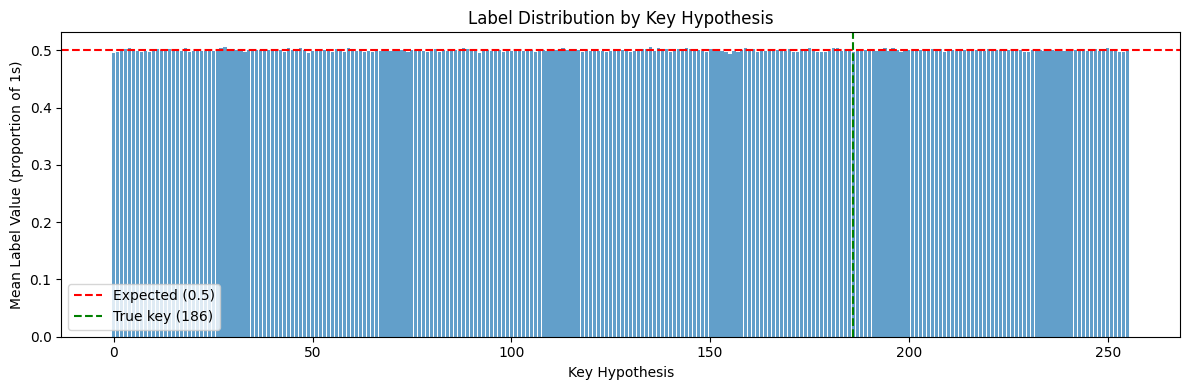

Label mean range: [0.4929, 0.5060]
True key label mean: 0.4977


In [72]:
# Check label distribution for all key hypotheses
labels_np = labels.numpy()

# For balanced labels, we expect ~50% 0s and ~50% 1s for each key
label_means = labels_np.mean(axis=0)  # (256,) - mean for each key

plt.figure(figsize=(12, 4))
plt.bar(range(256), label_means, alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--', label='Expected (0.5)')
plt.axvline(x=true_key, color='g', linestyle='--', label=f'True key ({true_key})')
plt.xlabel('Key Hypothesis')
plt.ylabel('Mean Label Value (proportion of 1s)')
plt.title('Label Distribution by Key Hypothesis')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Label mean range: [{label_means.min():.4f}, {label_means.max():.4f}]")
print(f"True key label mean: {label_means[true_key]:.4f}")


## 5. Check if Traces Actually Leak Information

The power traces should correlate with the Hamming weight of the S-box output.
Let's check if we can see any signal correlation.


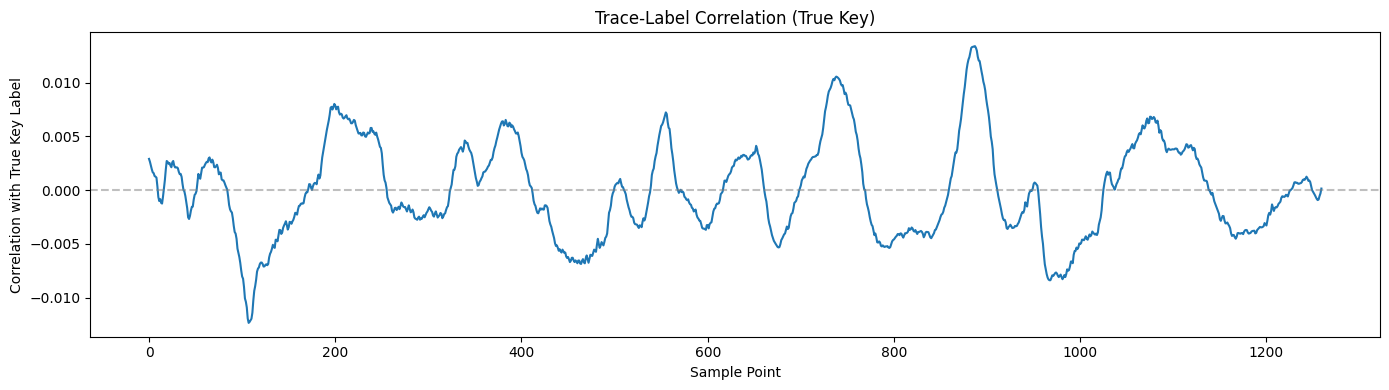

Max absolute correlation: 0.0134
Sample with max correlation: 887


In [73]:
# Compute correlation between traces and true key labels
traces_np = traces.numpy()
true_labels = labels_np[:, true_key]

# Point-wise correlation between each sample point and the label
correlations = np.zeros(traces_np.shape[1])
for i in range(traces_np.shape[1]):
    correlations[i] = np.corrcoef(traces_np[:, i], true_labels)[0, 1]

plt.figure(figsize=(14, 4))
plt.plot(correlations)
plt.xlabel('Sample Point')
plt.ylabel('Correlation with True Key Label')
plt.title('Trace-Label Correlation (True Key)')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Max absolute correlation: {np.max(np.abs(correlations)):.4f}")
print(f"Sample with max correlation: {np.argmax(np.abs(correlations))}")


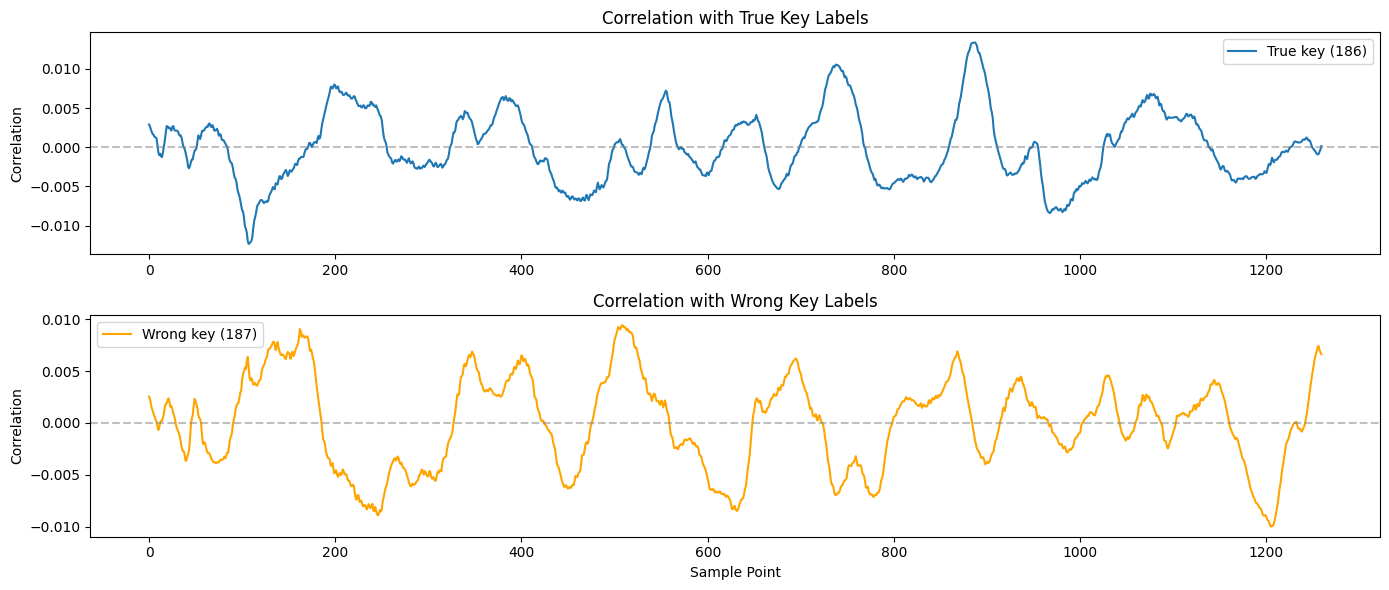

True key max |corr|:  0.0134
Wrong key max |corr|: 0.0100


In [74]:
# Compare correlation for true key vs wrong key
# Convert true_key to int to avoid uint8 overflow
true_key_int = int(true_key)
wrong_key = (true_key_int + 1) % 256
true_labels = labels_np[:, true_key_int]
wrong_labels = labels_np[:, wrong_key]

corr_true = np.zeros(traces_np.shape[1])
corr_wrong = np.zeros(traces_np.shape[1])

for i in range(traces_np.shape[1]):
    corr_true[i] = np.corrcoef(traces_np[:, i], true_labels)[0, 1]
    corr_wrong[i] = np.corrcoef(traces_np[:, i], wrong_labels)[0, 1]

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].plot(corr_true, label=f'True key ({true_key})')
axes[0].set_ylabel('Correlation')
axes[0].set_title('Correlation with True Key Labels')
axes[0].legend()
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

axes[1].plot(corr_wrong, label=f'Wrong key ({wrong_key})', color='orange')
axes[1].set_xlabel('Sample Point')
axes[1].set_ylabel('Correlation')
axes[1].set_title('Correlation with Wrong Key Labels')
axes[1].legend()
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"True key max |corr|:  {np.max(np.abs(corr_true)):.4f}")
print(f"Wrong key max |corr|: {np.max(np.abs(corr_wrong)):.4f}")


## 6. Check All Keys Correlation (Differential Analysis)


Computing correlations:   0%|          | 0/256 [00:00<?, ?it/s]

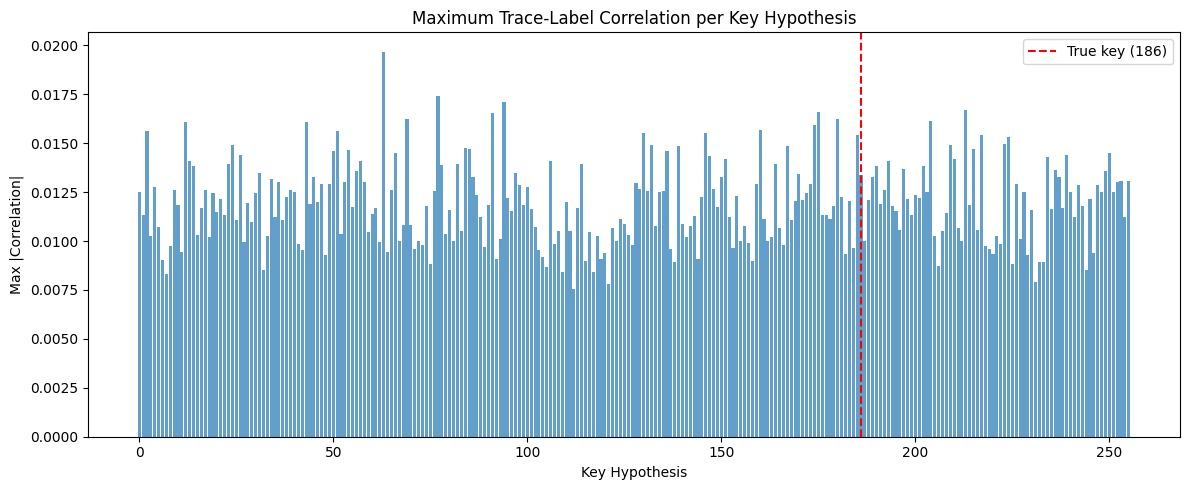


True key max correlation: 0.0134
Best key by correlation: 63 (corr: 0.0197)
True key rank: 60 / 256


In [75]:
# Compute max correlation for each key hypothesis
from tqdm.notebook import tqdm

max_correlations = np.zeros(256)

for k in tqdm(range(256), desc="Computing correlations"):
    k_labels = labels_np[:, k]
    corrs = np.array([np.corrcoef(traces_np[:, i], k_labels)[0, 1] 
                      for i in range(traces_np.shape[1])])
    max_correlations[k] = np.max(np.abs(corrs))

plt.figure(figsize=(12, 5))
plt.bar(range(256), max_correlations, alpha=0.7)
plt.axvline(x=true_key, color='r', linestyle='--', label=f'True key ({true_key})')
plt.xlabel('Key Hypothesis')
plt.ylabel('Max |Correlation|')
plt.title('Maximum Trace-Label Correlation per Key Hypothesis')
plt.legend()
plt.tight_layout()
plt.show()

# Rank of true key by correlation
rank = (max_correlations > max_correlations[true_key]).sum() + 1
print(f"\nTrue key max correlation: {max_correlations[true_key]:.4f}")
print(f"Best key by correlation: {np.argmax(max_correlations)} (corr: {np.max(max_correlations):.4f})")
print(f"True key rank: {rank} / 256")


## 7. Verify Model Forward Pass


In [76]:
# Import and create model
class CNNMO(nn.Module):
    def __init__(self, input_size=700, n_keys=256):
        super().__init__()
        self.n_keys = n_keys
        
        self.conv1 = nn.Conv1d(1, 4, kernel_size=32, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(4)
        self.pool1 = nn.AvgPool1d(2)
        
        self.conv2 = nn.Conv1d(4, 4, kernel_size=16, stride=1, padding=0)
        self.bn2 = nn.BatchNorm1d(4)
        self.pool2 = nn.AvgPool1d(4)
        
        self._flat_size = self._get_flat_size(input_size)
        self.heads = nn.ModuleList([nn.Linear(self._flat_size, 2) for _ in range(n_keys)])
    
    def _get_flat_size(self, input_size):
        x = torch.zeros(1, 1, input_size)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = torch.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        
        x = x.view(x.size(0), -1)
        outputs = [head(x) for head in self.heads]
        
        return outputs

model = CNNMO(input_size=700)
print(f"Model created with {model._flat_size} flattened features")


Model created with 316 flattened features


In [77]:
# Test forward pass
batch = traces[:10]  # Take first 10 traces
outputs = model(batch)

print(f"Number of outputs: {len(outputs)}")
print(f"Shape of each output: {outputs[0].shape}")
print(f"\nOutput for head 0 (first 3 traces):")
print(outputs[0][:3])

# Check output values
print(f"\nOutput statistics:")
all_outputs = torch.stack(outputs, dim=1)  # (batch, 256, 2)
print(f"Mean: {all_outputs.mean().item():.4f}")
print(f"Std:  {all_outputs.std().item():.4f}")
print(f"Min:  {all_outputs.min().item():.4f}")
print(f"Max:  {all_outputs.max().item():.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x596 and 316x2)

## 8. Check Loss Computation


In [78]:
# Verify loss computation
criterion = nn.CrossEntropyLoss()

batch_traces = traces[:50]
batch_labels = labels[:50]

outputs = model(batch_traces)

# Compute loss for each head
losses = []
for k in range(256):
    loss_k = criterion(outputs[k], batch_labels[:, k])
    losses.append(loss_k.item())

total_loss = sum(losses)

print(f"Per-head loss statistics:")
print(f"  Mean:   {np.mean(losses):.4f}")
print(f"  Std:    {np.std(losses):.4f}")
print(f"  Min:    {np.min(losses):.4f}")
print(f"  Max:    {np.max(losses):.4f}")
print(f"\nTotal loss: {total_loss:.4f}")
print(f"Expected random loss: {256 * 0.693:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x596 and 316x2)

In [ ]:
# Check label types being passed to loss
print(f"Labels dtype: {batch_labels.dtype}")
print(f"Labels for key 0: {batch_labels[:5, 0]}")
print(f"Output for key 0: {outputs[0][:5]}")

# CrossEntropyLoss expects:
# - input: (N, C) where C = number of classes
# - target: (N,) with class indices
print(f"\nCrossEntropyLoss input shape: {outputs[0].shape}")
print(f"CrossEntropyLoss target shape: {batch_labels[:, 0].shape}")
print(f"CrossEntropyLoss target values: {torch.unique(batch_labels[:, 0])}")


Labels dtype: torch.int64
Labels for key 0: tensor([0, 0, 0, 1, 0])
Output for key 0: tensor([[-0.1240,  0.0584],
        [-0.1270,  0.1217],
        [-0.1314,  0.1050],
        [-0.1035,  0.1002],
        [-0.1193,  0.1378]], grad_fn=<SliceBackward0>)

CrossEntropyLoss input shape: torch.Size([50, 2])
CrossEntropyLoss target shape: torch.Size([50])
CrossEntropyLoss target values: tensor([0, 1])


## 9. Gradient Flow Check


In [ ]:
# Check if gradients flow properly
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer.zero_grad()
outputs = model(batch_traces)

total_loss = sum(criterion(outputs[k], batch_labels[:, k]) for k in range(256))
total_loss.backward()

# Check gradients
print("Gradient statistics per layer:")
for name, param in model.named_parameters():
    if param.grad is not None:
        grad = param.grad
        print(f"{name:30s} | mean: {grad.mean().item():>10.6f} | std: {grad.std().item():>10.6f} | max: {grad.abs().max().item():>10.6f}")


Gradient statistics per layer:
conv1.weight                   | mean:   0.088212 | std:   1.207382 | max:   3.100830
conv1.bias                     | mean:   0.000000 | std:   0.000001 | max:   0.000001
bn1.weight                     | mean:   0.000186 | std:   0.666211 | max:   0.981824
bn1.bias                       | mean:   0.003499 | std:   0.480029 | max:   0.708887
conv2.weight                   | mean:   0.041254 | std:   0.934424 | max:   3.296244
conv2.bias                     | mean:  -0.000000 | std:   0.000001 | max:   0.000001
bn2.weight                     | mean:   3.535461 | std:   0.978646 | max:   4.527690
bn2.bias                       | mean:   2.886879 | std:   1.520087 | max:   4.512465
heads.0.weight                 | mean:  -0.000000 | std:   0.062731 | max:   0.201757
heads.0.bias                   | mean:  -0.000000 | std:   0.142761 | max:   0.100947
heads.1.weight                 | mean:  -0.000000 | std:   0.099746 | max:   0.318379
heads.1.bias           

## 10. Quick Overfitting Test (Single Batch)

If the model can't overfit a tiny batch, something is fundamentally wrong.


Step 20: Loss = 148.5444
Step 40: Loss = 109.4654
Step 60: Loss = 73.2016
Step 80: Loss = 45.2217
Step 100: Loss = 33.3982


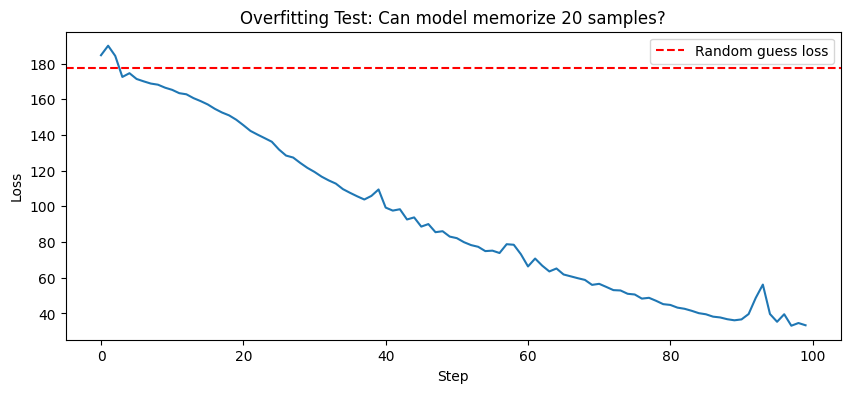


Initial loss: 184.6660
Final loss: 33.3982
Loss reduction: 151.2678


In [ ]:
# Try to overfit on a single small batch - if model can't overfit, there's a problem
torch.manual_seed(42)
small_model = CNNMO(input_size=700)
small_optimizer = torch.optim.Adam(small_model.parameters(), lr=0.01)  # Higher LR

# Use tiny batch
tiny_traces = traces[:20]
tiny_labels = labels[:20]

losses_history = []

for step in range(100):
    small_optimizer.zero_grad()
    outputs = small_model(tiny_traces)
    
    total_loss = sum(criterion(outputs[k], tiny_labels[:, k]) for k in range(256))
    total_loss.backward()
    small_optimizer.step()
    
    losses_history.append(total_loss.item())
    
    if (step + 1) % 20 == 0:
        print(f"Step {step+1}: Loss = {total_loss.item():.4f}")

plt.figure(figsize=(10, 4))
plt.plot(losses_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Overfitting Test: Can model memorize 20 samples?')
plt.axhline(y=256*0.693, color='r', linestyle='--', label='Random guess loss')
plt.legend()
plt.show()

print(f"\nInitial loss: {losses_history[0]:.4f}")
print(f"Final loss: {losses_history[-1]:.4f}")
print(f"Loss reduction: {losses_history[0] - losses_history[-1]:.4f}")


## 11. Single-Head Sanity Check

Train a simple model on just ONE key hypothesis to verify the setup works.


Epoch 10: Loss = 0.7292, Accuracy = 0.5170
Epoch 20: Loss = 0.7292, Accuracy = 0.5170
Epoch 30: Loss = 0.7291, Accuracy = 0.5170
Epoch 40: Loss = 0.7290, Accuracy = 0.5170
Epoch 50: Loss = 0.7287, Accuracy = 0.5228


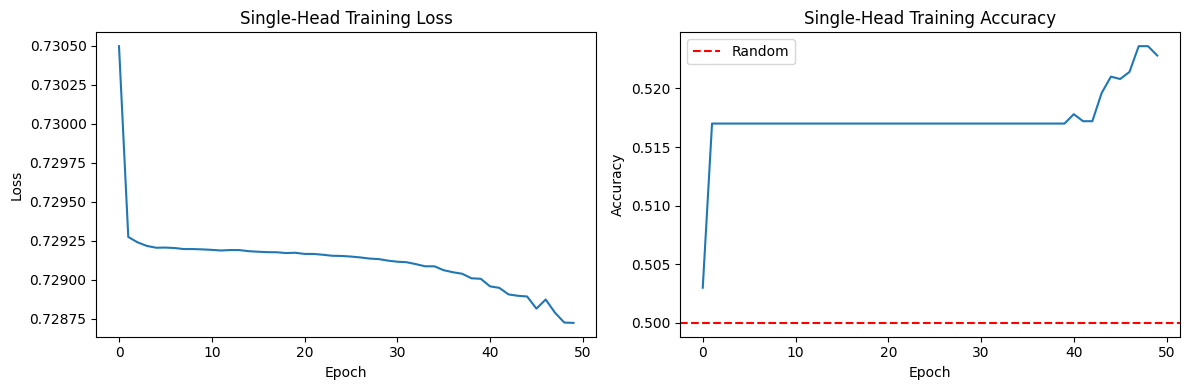

In [ ]:
# Simple CNN for single key prediction
class SimpleCNN(nn.Module):
    def __init__(self, input_size=700):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=32)
        self.pool1 = nn.AvgPool1d(4)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=16)
        self.pool2 = nn.AvgPool1d(4)
        
        # Calculate flat size
        x = torch.zeros(1, 1, input_size)
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        flat_size = x.view(1, -1).size(1)
        
        self.fc = nn.Linear(flat_size, 2)  # Binary classification
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Train on TRUE KEY labels only
simple_model = SimpleCNN()
simple_opt = torch.optim.Adam(simple_model.parameters(), lr=0.001)

# Use subset of data
n_samples = 5000
train_traces = traces[:n_samples]
train_labels = labels[:n_samples, true_key]  # Only true key labels

simple_losses = []
simple_accs = []

for epoch in range(50):
    simple_model.train()
    
    # Mini-batch training
    batch_size = 256
    epoch_loss = 0
    correct = 0
    
    for i in range(0, n_samples, batch_size):
        batch_x = train_traces[i:i+batch_size]
        batch_y = train_labels[i:i+batch_size]
        
        simple_opt.zero_grad()
        out = simple_model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        simple_opt.step()
        
        epoch_loss += loss.item()
        correct += (out.argmax(1) == batch_y).sum().item()
    
    avg_loss = epoch_loss / (n_samples // batch_size)
    accuracy = correct / n_samples
    simple_losses.append(avg_loss)
    simple_accs.append(accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(simple_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Single-Head Training Loss')

axes[1].plot(simple_accs)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Single-Head Training Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


## 12. Summary & Diagnosis
